# Define Input Parameters

In [18]:
BATCH_FILES: int = 150
BATCH_DIRS: int = 5

---

# Import Section

In [19]:
import tensorflow as tf
from tensorflow import keras

import os
import librosa

import numpy as np

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense

from sklearn.model_selection import train_test_split

import math

import matplotlib.pyplot as plt
%matplotlib inline


# Preprocessing Data

In [20]:
def preprocess(parent_dir = "./music_data", num_segment = 10, sample_rate = 22050, num_mfcc = 40, num_fft = 2048, hop_length = 512):
    X = list()
    Y = list()

    samples_per_segment = int(sample_rate*30/num_segment)

    classes = os.listdir(parent_dir)[:BATCH_DIRS]
    sub_dirs = classes

    for sub_dir in sub_dirs:
        files = os.listdir(parent_dir + "/" + sub_dir)
        
        j = 0
        for file in files:
            j += 1
            if (j > BATCH_FILES): break
            
            a, sr = librosa.load(parent_dir + "/" + sub_dir + "/" + file, sr = sample_rate)
            
            for n in range(num_segment):
                mfcc = librosa.feature.mfcc(y=a[samples_per_segment*n: samples_per_segment*(n+1)],
                                            sr=sample_rate, n_mfcc=num_mfcc, n_fft=num_fft,
                                            hop_length=hop_length)
                mfcc = mfcc.T
                
                if len(mfcc) == math.ceil(samples_per_segment / hop_length):
                    X.append(mfcc.tolist())
                    Y.append(sub_dirs.index(sub_dir))
                    
    X = np.array(X, dtype="float32")
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

    Y = to_categorical(Y, num_classes=BATCH_DIRS)
    
    return (X, Y)

# Preparing Data

In [21]:
def prepare():
    X, Y = preprocess()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train)
    return (X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [22]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = prepare()

# Creating a CNN Model

In [23]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="valid", input_shape=X_train.shape[1:]),
    MaxPooling2D(2, padding="same"),
    
    Conv2D(128, (3,3), activation="relu", padding="valid"),
    MaxPooling2D(2, padding="same"),
    Dropout(0.3),
    
    Conv2D(128, (3,3), activation="relu", padding="valid"),
    MaxPooling2D(2, padding="same"),
    Dropout(0.3),
    
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dense(BATCH_DIRS, activation="softmax"),
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 38, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 17, 128)       36992     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 9, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 31, 9, 128)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 7, 128)       

# Training Model

In [24]:
history = \
model.fit(X_train, Y_train,
            batch_size=64,
            epochs=30, 
            validation_data=(X_test, Y_test), 
            shuffle=True,)

Epoch 1/30
64/64 [==============================] - 14s 210ms/step - loss: 1.6257 - accuracy: 0.3080 - val_loss: 1.4628 - val_accuracy: 0.3519
Epoch 2/30
64/64 [==============================] - 16s 249ms/step - loss: 1.3439 - accuracy: 0.4470 - val_loss: 1.3936 - val_accuracy: 0.4064
Epoch 3/30
64/64 [==============================] - 13s 196ms/step - loss: 1.2672 - accuracy: 0.4860 - val_loss: 1.2293 - val_accuracy: 0.5059
Epoch 4/30
64/64 [==============================] - 13s 197ms/step - loss: 1.1807 - accuracy: 0.5246 - val_loss: 1.1710 - val_accuracy: 0.5409
Epoch 5/30
64/64 [==============================] - 12s 192ms/step - loss: 1.1387 - accuracy: 0.5411 - val_loss: 1.0821 - val_accuracy: 0.5658
Epoch 6/30
64/64 [==============================] - 13s 202ms/step - loss: 1.1131 - accuracy: 0.5614 - val_loss: 1.1301 - val_accuracy: 0.5628
Epoch 7/30
64/64 [==============================] - 12s 190ms/step - loss: 1.0603 - accuracy: 0.5861 - val_loss: 1.0342 - val_accuracy: 0.6072

# Plotting Loss and Accuracy Graph

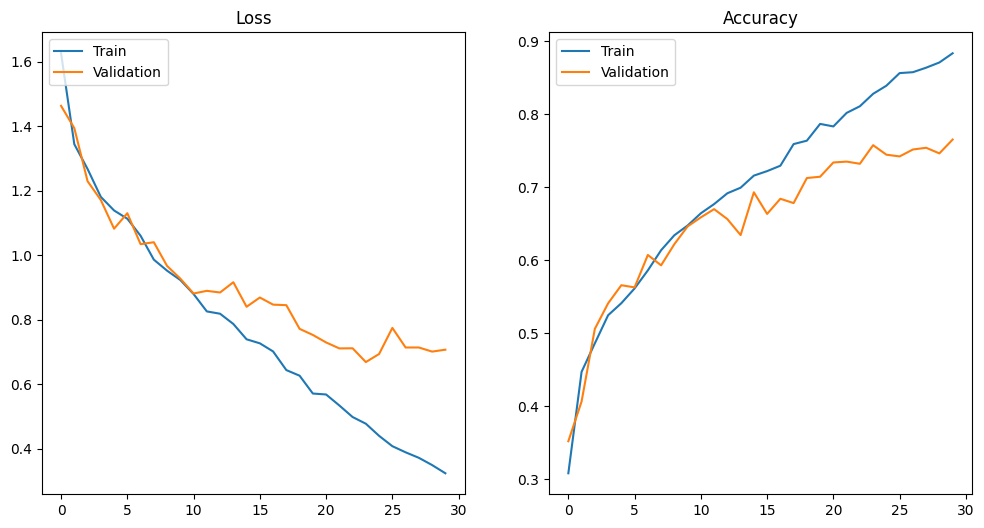

In [25]:
fig, axis = plt.subplots(1, 2)
fig.set_size_inches(12,6)

axis[0].plot(history.history['loss'])
axis[0].plot(history.history['val_loss'])
axis[0].set_title("Loss")
axis[0].legend(['Train', 'Validation'], loc='upper left')

axis[1].plot(history.history['accuracy'])
axis[1].plot(history.history['val_accuracy'])
axis[1].set_title("Accuracy")
axis[1].legend(['Train', 'Validation'], loc='upper left')